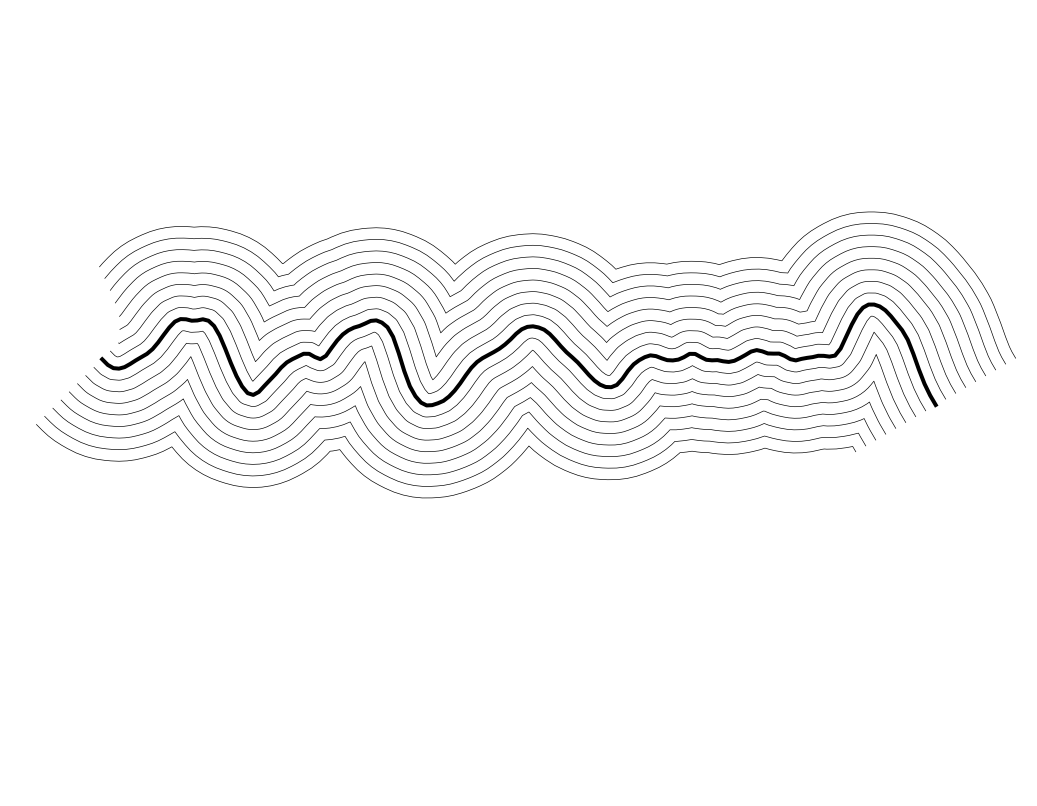

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from noise import pnoise1
from shapely.geometry import LineString
import svgwrite

#------------------------------
# Setup document. Size in points (1 inch = 72 pts)
inch_pt = 72
width_in, height_in = 11, 8.5
width_pt, height_pt = width_in * inch_pt, height_in * inch_pt


#------------------------------
# Generate wiggly polyline with Perlin noise
n_points = 150
x_vals = np.linspace(inch_pt, width_pt-inch_pt, n_points)
y_center = height_pt / 2
noise_amplitude = inch_pt * 1.0
noise_scale = 0.015
noise_offset = 123.45

y_vals = []
for x in x_vals:
    x_input = x * noise_scale + noise_offset
    noise_val = pnoise1(
        x_input,
        octaves=3,
        persistence=0.2
    )
    y = y_center + noise_amplitude * (noise_val - 0.5)
    y_vals.append(y)

points = list(zip(x_vals, y_vals))


#------------------------------
# Create a Shapely LineString from the original points
centerline = LineString(points)

# Generate multiple offset curves
num_offsets = 8
offset_spacing = 9  # in points; 0.125"

left_offsets = []
right_offsets = []

for i in range(1, num_offsets + 1):
    dist = i * offset_spacing
    left = centerline.parallel_offset(dist, side='left', join_style=1)
    right = centerline.parallel_offset(dist, side='right', join_style=1)
    left_offsets.append(left)
    right_offsets.append(right)

# Convert offset curves to SVG-friendly point lists
def shapely_coords_to_list(geom):
    if geom.geom_type == 'LineString':
        return list(geom.coords)
    elif geom.geom_type == 'MultiLineString':
        return [list(part.coords) for part in geom.geoms]
    else:
        return []


#------------------------------
# Display with matplotlib
fig, ax = plt.subplots(figsize=(width_in, height_in), dpi=96)

# Plot centerline
ax.plot(x_vals, y_vals, color='black', linewidth=3)

# Plot left offset curves
for offset in left_offsets:
    if offset.geom_type == 'LineString':
        x, y = offset.xy
        ax.plot(x, y, color='black', linewidth=0.5)
    elif offset.geom_type == 'MultiLineString':
        for segment in offset.geoms:
            x, y = segment.xy
            ax.plot(x, y, color='black', linewidth=0.5)

# Plot right offset curves
for offset in right_offsets:
    if offset.geom_type == 'LineString':
        x, y = offset.xy
        ax.plot(x, y, color='black', linewidth=0.5)
    elif offset.geom_type == 'MultiLineString':
        for segment in offset.geoms:
            x, y = segment.xy
            ax.plot(x, y, color='black', linewidth=0.5)

ax.set_xlim(0, width_pt)
ax.set_ylim(height_pt, 0)  # Flip Y-axis to match SVG coordinate system
ax.set_aspect('equal')
ax.axis('off')
plt.tight_layout()
plt.show()


#------------------------------
# Export to SVG
dwg = svgwrite.Drawing("wiggly_polyline.svg", size=(f"{width_pt}px", f"{height_pt}px"))

# Original centerline (1pt)
dwg.add(dwg.polyline(points=points, stroke='black', fill='none', stroke_width=1))

# Helper: convert shapely LineString or MultiLineString to point lists
def extract_svg_lines(geometry):
    if geometry.geom_type == 'LineString':
        return [list(geometry.coords)]
    elif geometry.geom_type == 'MultiLineString':
        return [list(part.coords) for part in geometry.geoms]
    else:
        return []

# Draw offsets (0.5pt)
for offset in left_offsets + right_offsets:
    for line in extract_svg_lines(offset):
        dwg.add(dwg.polyline(points=line, stroke='black', fill='none', stroke_width=0.5))

dwg.save()